## K Means Clustering, Agglomerative Clustering, DBSCAN Clustering:
Objective :

1. Perform featurization BoW,TFIDF, Avg Word2Vec, tf-idf-Word2Vec.
2. At the end of the assignment, please elaborate on the step by step procedure you followed to solve the assignment.

## K-Means Clustering:

1. Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)
2. Once after you find the k clusters, plot the word cloud per each cluster so that at a single go we can analyze the words in a cluster.
3. Also apply the k-medoids algorithm as well.

### Step-By-Step procedure

1. In this, we need to work with all 4-vectorizers (BOW, TFIDF,Avg w2v and TF-IDF weighted w2v) where we will convert our texted review into numerical(vector) form in order to apply any Model on it.

2. After that we will take our cleandedtext(i.e cleand text means we have already cleaned our data by removing stops words, other this which are going to affect our model) and then we will take only test data not their respective class lable because as we know we are goint to apply K-means clustering algo which do not required class lables. what is does is it mainly group/clusters the similar data points

3. After that as we know K i.e n_clusters is not specified, the optimal number of clusters we need to estimate using a technique called the elbow method. The elbow method plots the loss and K(n_clusters). and try to get the best k. And as we know when k increae the loss will decrease, and the point where the loss is slightly change with direction then that will be our elbow point

4. After getting best k i.e n_clusters we will implemsnt k-means with best k(n_clusters) which we get using elbow method. And try to plot the revies of each clusters in word cloud 

5. As we know plm with k-means is not interpretable so we will try to implement k-medoids and repeat 3 and 4 step 

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
#taking cleaned data i.e in Reviews table  from final sql database
#making connection with database 
conn = sqlite3.connect('final.sqlite') 
final = pd.read_sql_query(""" SELECT * FROM Reviews""", conn) 

In [7]:
final = final[:100000]
print(len(final))

100000


In [8]:
CleanedText = final['CleanedText'];
text=final.CleanedText.values    

In [9]:
reviews = final['Text'].values
from tqdm import tqdm
import os

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
import seaborn as sns; 

# code borrowed from https://raw.githubusercontent.com/letiantian/kmedoids/master/kmedoids.py
# this function finds clusters using k-medoids method 
# returns C : dictionary of all the reviews belonging to particular cluster label
# returns M : contains the index of central review of cluster
import random

def kMedoid(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C


def cluster_wordcloud_generated_image_fun(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100,stopwords=stopwords ,background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    

## Bow
Applying Bow vectorizer on data

In [10]:
#BOW 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10)
vocabulary= vectorizer.fit(text)
#print("the shape of out text BOW vectorizer ",vocabulary.get_shape())

bow_data= vectorizer.transform(text)
print("the shape of out text BOW vectorizer ",bow_data.get_shape())

the shape of out text BOW vectorizer  (100000, 8422)


## K-Means Clustering hyperparameter tuning:
Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)

In [6]:
from sklearn.cluster import KMeans

n_clusters_lists = range(1,10)
cluster_errors = []

for clusters in tqdm(n_clusters_lists):
    model = KMeans(n_clusters = clusters, n_init=5)
    model.fit(bow_data)
    cluster_errors.append(model.inertia_)

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:32:26<00:00, 731.25s/it]


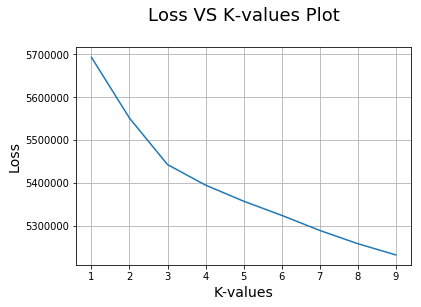

In [7]:
# Draw Loss VS K values plot
plt.plot(n_clusters_lists, cluster_errors)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

#### Once after you find the k clusters, plot the word cloud per each cluster so that at a single go we can analyze the words in a cluster.

In [14]:
optimal_n_clusters = 3

In [8]:
# Implementing K-Means using optimal value of n_clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, n_jobs=-1).fit(bow_data)

In [75]:
# getting original text i.e review column from the dataset 
reviews = final['Text'].values
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_2.append(reviews[i])
    else :
        cluster_3.append(reviews[i]) 

## Ploting the word cloud per each cluster so that we can analyze the words in a cluster.
### Cluster - 1 review 

Review - 1
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


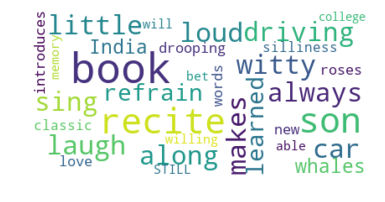

Review - 2
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


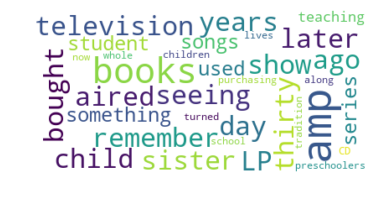

Review - 3
Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.


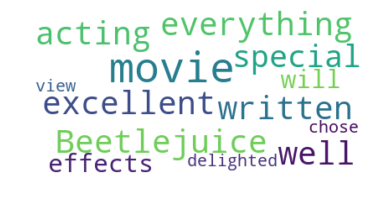

In [98]:
count = 1;
for i in range(len(cluster_1)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_1[i])
        cluster_wordcloud_generated_image_fun(cluster_1[i])
    count +=1

### Cluster - 2 reviews

Review - 1
The spectra paste food colors are simply fantastic. They provide a depth and clarity of color that is impossible to achieve with liquid food colors. And the hues are beautiful and distinctive. The black and red, two colors which are very difficult to get when dying frostings, etc. are especially nice - probably the best of any manufacturer I have tried.<p>For those who had questions, I am not 100% certain about the sizes, but if the set is the same as mine, the bottles are 3/4 ounce. While that might not seem like much, all you need is a dot of this thick gel paste at the end of a toothpick to color large amounts of material. So there is plenty of coloring ability in each bottle - many, many times more than a same sized liquid food color bottle. <p>Highly recommended and at a really good price at the time of this review.


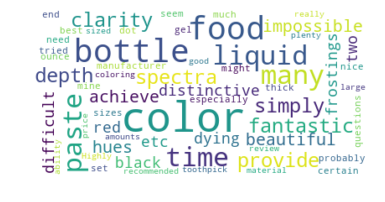

Review - 2
Long live Camper Van Beethoven!! This is a blessing for long time CVB fans who didn't have a chance to upgrade their collection to CD before most of this went out of print.  Wow, where to begin?  CVB was a band that matured on record, so to speak, so this is really a fascinating and entertaining listen from beginning to end.<br />  Of course you get the endearing and humorous debut album with goofy anthems ala "Take the Skinheads Bowling" and various folk/ska instrumentals; the increasingly warped and psychedelic "II & III"; and this collections' centerpiece: the self titled 3rd album!!  Forget the editorial remark above about them "scratching their heads out loud" on this because there's nothing confused, unfocused, or tentative about this album.  I'd say it's a characteristically irreverent and eclectic psych-rock masterpiece.  The song writing has fully matured with the sarcastic humor still intact, and it seems to be intentionally conceived as an album that gets stranger

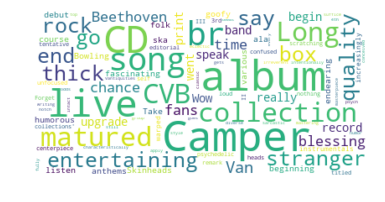

Review - 3
Well, maybe not &quot;the&quot; greatest, but one of the best.  This set brings together the earlier stuff which is slightly more quirky than the two albums they did for Virgin.  Some of it is even sort of challenging, but mixed in are some songs as lovable as a soft fluffy kitten with a ball of yarn like &quot;Take the Skinheads Bowling&quot; and &quot;Good Guys &amp; Bad Guys&quot;.  There was this one story about them one time when they played in Philly and stayed with the Dead Milkmen for the night.  It's a great story, but probably shouldn't be repeated here.  When I first picked up a guitar (actually the first time I picked up a guitar after hearing the third album) I wanted to play &quot;Good Guys &amp; Bad Guys&quot; but I was the only keyboard player in the band so I got stuck playing the keyboard part which is a lot more tasty after you play it a few times.  We can thank our lucky stars that these guys are touring again.  I was heartbroken when they broke up and Cr

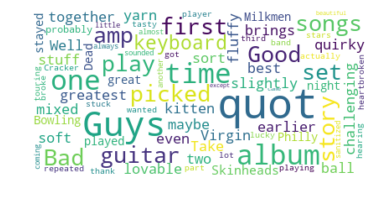

In [99]:
count = 1;
for i in range(len(cluster_2)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_2[i])
        cluster_wordcloud_generated_image_fun(cluster_2[i])
    count +=1

### Cluster - 3 reviews

Review - 1
For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for maintaining a healthy natural balance during the flu season. From previous experiences in tasting the Tazo brand, both of the bottled and boxed products, they have proven to be unsurpassed for quality and flavor. Once I've tried their teas they immediately became my drink of choice. <p>The Zen Green Tea Blend is a wonderful one that has only a few ingredients with no artificial anything. And thankfully, doesn't boast the addition of fortified vitamins in some senseless amount. It truly is an enlightening blend of green tea, spearmint, lemongrass and lemon verbena. Thus making it versatile refreshment for anytime of the day, whether it's right after meals or between meals, or just before bedtime. Generally light and mild tasting, but that will depend upon how long you steep it and if you add a sweetener of some for

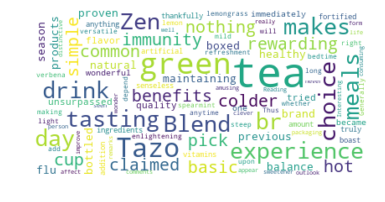

Review - 2
Blend a little apple cider mix into your Tazo Passion Tea and see what happens. This creates a magical apple cider experience with hints of cranberry and hibiscus flowers gathered in an ancient land.<br /><br />Snuggle Up Spiced Cider is a good choice because you can then spoon in the exact amount you desire, but packets of cider work equally well. This is the type of tea you would expect to enjoy after skiing in some distant forest where you are also munching on homemade brownies or eggnog cookies. Apple cider also works very well with the Gypsy Teas, especially the Lemon Jasmine.<br /><br />The deep purple/red color and hibiscus fragrance of Tazo Tea is enough to make anyone passionate about tea. Yet, is this really tea? It looks like tea, but it is really an herbal infusion made by steeping hibiscus flowers, orange peel, licorice, cinnamon, rose hips, lemongrass and red poppy in a swirling of hot water.<br /><br />The original flavor is also slightly reminiscent of hot ap

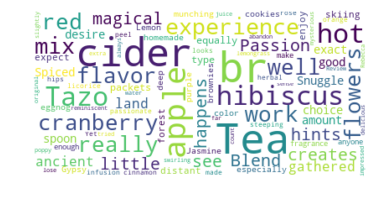

Review - 3
"There are few hours in life more agreeable than the hour dedicated to the ceremony known as afternoon tea." -Henry James, Portrait of a Lady<br /><br />This "English Breakfast" style tea is quite satisfying and has a rich flavor that is quite delicious.<br /><br />I'd like to say that their teas are best steeped for an extra 5-10 minutes to draw out all the delicious flavors. You can use a teapot or a coffee maker to make tea. Simply put the tea in a coffee filter or the tea bags in the coffee pot, then allow the boiling water to drip over the tea leaves.<br /><br />The sensual blend of exotic spices, teas and herbs used in their teas include a mixture of the following: Black tea, green tea, hibiscus flowers, chamomile flowers, lemongrass, spearmint leaves, blackberry leaves, cinnamon, Rooibos, Gingerroot, rose hips, orange peel, rose petals, licorice root, safflowers, black pepper, lemon verbena leaves, cardamom, cloves, peppermint leaves, chicory, sarsaparilla root, lemon

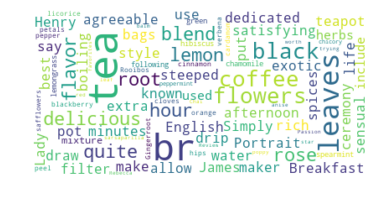

In [100]:
count = 1;
for i in range(len(cluster_3)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_3[i])
        cluster_wordcloud_generated_image_fun(cluster_3[i])
    count +=1

## k-medoids algorithm Implementation


In [15]:
# code reference https://github.com/letiantian/kmedoids
from sklearn.metrics.pairwise import pairwise_distances
bow_data1 = bow_data[0:10000,:]
# distance matrix
D = pairwise_distances(bow_data1, metric='euclidean')

M, C = kMedoid(D, k = optimal_n_clusters)

****************************************************************************************************
Cluster -  1
No of reviews present in Cluster 1  are =  8
****************************************************************************************************
Review -  1
This is the worst dried mango product. I tasted a few and threw away the whole bag. Ingredient doesn't read it used sugar and preservatives. I thought it was natural and no sugar. But when I saw it I think it used bunch of sugar and also used preservative. Well if they missed ingredients that's still ok only if it tastes good because other products also use sugar and preservative. However it was the worst dried mango I ever had. It is neither pleasing nor healthful. I already lost money spending on it and didn't want to bother my mouth nor my health with the worst. So, I threw away the whole bag decisively. No attachment. I recommend philipine imported dired mango products. 7D mango is fine. For your reference, I bough

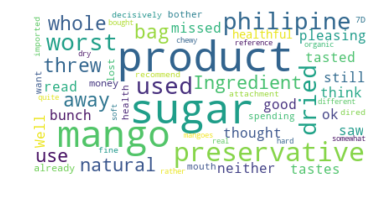

Review -  2
This is the worst dried mango product. I tasted a few and threw away the whole bag. Ingredient doesn't read it used sugar and preservatives. I thought it was natural and no sugar. But when I saw it I think it used bunch of sugar and also used preservative. Well if they missed ingredients that's still ok only if it tastes good because other products also use sugar and preservative. However it was the worst dried mango I ever had. It is neither pleasing nor healthful. I already lost money spending on it and didn't want to lose my health nor bother my mouth with the worst. So, I threw away the whole bag decisively. No attachment. I recommend philipine imported dired mango products. 7D mango is fine. For your reference, I bought some organic or natural dried mangoes. They are quite different from philipine products. They are real dry and somewhat hard rather than soft and chewy like philipine products. They don't taste as good as philpine products, but they use no sugar no pres

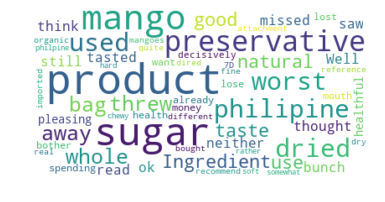



****************************************************************************************************
Cluster -  2
No of reviews present in Cluster 2  are =  9696
****************************************************************************************************
Review -  1
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


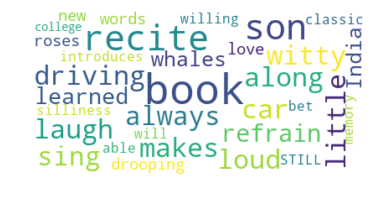

Review -  2
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


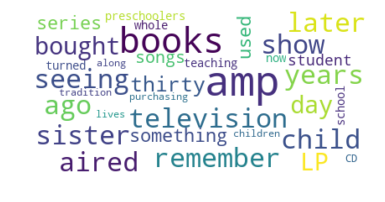



****************************************************************************************************
Cluster -  3
No of reviews present in Cluster 3  are =  296
****************************************************************************************************
Review -  1
For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for maintaining a healthy natural balance during the flu season. From previous experiences in tasting the Tazo brand, both of the bottled and boxed products, they have proven to be unsurpassed for quality and flavor. Once I've tried their teas they immediately became my drink of choice. <p>The Zen Green Tea Blend is a wonderful one that has only a few ingredients with no artificial anything. And thankfully, doesn't boast the addition of fortified vitamins in some senseless amount. It truly is an enlightening blend of green tea, spearmint, lemongrass and lemo

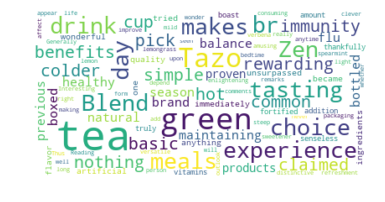

Review -  2
Blend a little apple cider mix into your Tazo Passion Tea and see what happens. This creates a magical apple cider experience with hints of cranberry and hibiscus flowers gathered in an ancient land.<br /><br />Snuggle Up Spiced Cider is a good choice because you can then spoon in the exact amount you desire, but packets of cider work equally well. This is the type of tea you would expect to enjoy after skiing in some distant forest where you are also munching on homemade brownies or eggnog cookies. Apple cider also works very well with the Gypsy Teas, especially the Lemon Jasmine.<br /><br />The deep purple/red color and hibiscus fragrance of Tazo Tea is enough to make anyone passionate about tea. Yet, is this really tea? It looks like tea, but it is really an herbal infusion made by steeping hibiscus flowers, orange peel, licorice, cinnamon, rose hips, lemongrass and red poppy in a swirling of hot water.<br /><br />The original flavor is also slightly reminiscent of hot a

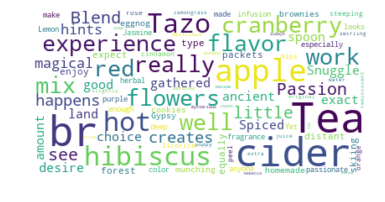

In [16]:
# Getting the reviews in all clusters
for label in C:
    print("*" * 100)
    print("Cluster - ",label+1)
    print('No of reviews present in Cluster',label+1,' are = ',C[label].shape[0])
    print("*" * 100)
#     print('\n')
    review_count = 1;
    for label_idx in C[label]:
        if review_count == 3:
            break;
        else:
            print('Review - ',review_count)
            print(reviews[label_idx])
            cluster_wordcloud_generated_image_fun(reviews[label_idx])
            review_count = review_count+1
    print('\n')


*** BOW ENDS ***

## TF-IDF

In [17]:
#tfidf 
tf_idf_vect = TfidfVectorizer()
vocabulary = tf_idf_vect.fit(text)
#print("the shape of out text TF-IDF vectorizer ",tf_idf_x_tr.get_shape())
tf_idf_data = tf_idf_vect.transform(text)
print("the shape of out text TF-IDF vectorizer ",tf_idf_data.get_shape())

the shape of out text TF-IDF vectorizer  (100000, 37164)


### K-Means Clustering hyperparameter tuning

In [103]:
n_clusters_lists = range(1,10)
cluster_errors = []

for clusters in tqdm(n_clusters_lists):
    model = KMeans(n_clusters = clusters, n_init=5)
    model.fit(tf_idf_data)
    cluster_errors.append(model.inertia_)

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [2:19:47<00:00, 971.40s/it]


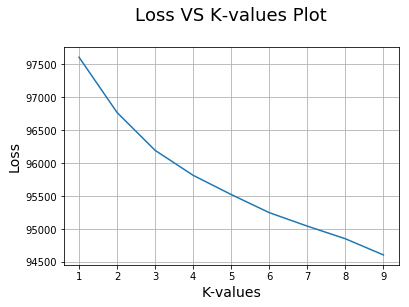

In [104]:
# Draw Loss VS K values plot
plt.plot(n_clusters_lists, cluster_errors)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

### K-Means Clustering implementation  with best n_clusters 

In [105]:
optimal_n_clusters = 3
# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_n_clusters, n_jobs=-1).fit(tf_idf_data)

In [106]:
# getting original text i.e review column from the dataset 
reviews = final['Text'].values
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_2.append(reviews[i])
    else :
        cluster_3.append(reviews[i]) 

## Ploting the word cloud per each cluster so that we can analyze the words in a cluster.
### Cluster - 1 review

Review - 1
For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for maintaining a healthy natural balance during the flu season. From previous experiences in tasting the Tazo brand, both of the bottled and boxed products, they have proven to be unsurpassed for quality and flavor. Once I've tried their teas they immediately became my drink of choice. <p>The Zen Green Tea Blend is a wonderful one that has only a few ingredients with no artificial anything. And thankfully, doesn't boast the addition of fortified vitamins in some senseless amount. It truly is an enlightening blend of green tea, spearmint, lemongrass and lemon verbena. Thus making it versatile refreshment for anytime of the day, whether it's right after meals or between meals, or just before bedtime. Generally light and mild tasting, but that will depend upon how long you steep it and if you add a sweetener of some for

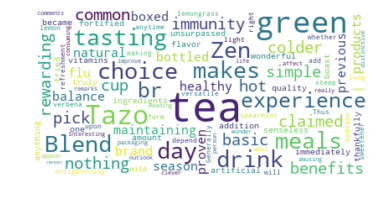

Review - 2
Blend a little apple cider mix into your Tazo Passion Tea and see what happens. This creates a magical apple cider experience with hints of cranberry and hibiscus flowers gathered in an ancient land.<br /><br />Snuggle Up Spiced Cider is a good choice because you can then spoon in the exact amount you desire, but packets of cider work equally well. This is the type of tea you would expect to enjoy after skiing in some distant forest where you are also munching on homemade brownies or eggnog cookies. Apple cider also works very well with the Gypsy Teas, especially the Lemon Jasmine.<br /><br />The deep purple/red color and hibiscus fragrance of Tazo Tea is enough to make anyone passionate about tea. Yet, is this really tea? It looks like tea, but it is really an herbal infusion made by steeping hibiscus flowers, orange peel, licorice, cinnamon, rose hips, lemongrass and red poppy in a swirling of hot water.<br /><br />The original flavor is also slightly reminiscent of hot ap

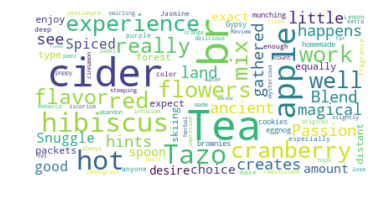

Review - 3
I think that this is a great Chai! Far from sweet.. I found it very unsweet (and that is exactly why I like it). The Tiger Spice is a great blend of Black Tea, Cinnamon, Ginger, herbs, and more. I was not a big tea drinker (until now) but this is a very smooth and light Chai. All you do is add water and it comes out creamy and perfect (some people add milk but this Chai mix already has a creamer in it). This is my new healthy breakfast wake me up. It is great. I have many Indian friends with whom I drink freshly made Chai with and this is as close as you can come with an instant blend. I highly recommend this.


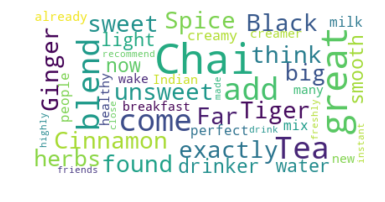

In [107]:
count = 1;
for i in range(len(cluster_1)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_1[i])
        cluster_wordcloud_generated_image_fun(cluster_1[i])
    count +=1

### Cluster - 2 review

Review - 1
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


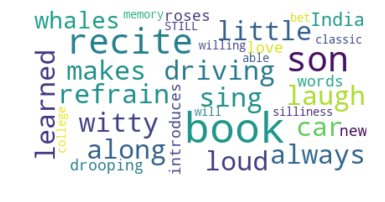

Review - 2
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


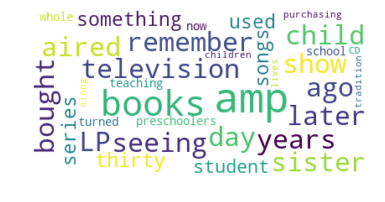

Review - 3
Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.


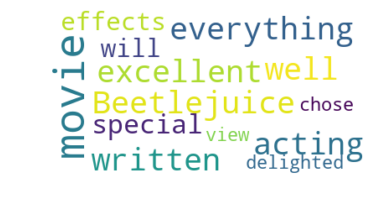

In [108]:
count = 1;
for i in range(len(cluster_2)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_2[i])
        cluster_wordcloud_generated_image_fun(cluster_2[i])
    count +=1

### Cluster - 3 review

Review - 1
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).


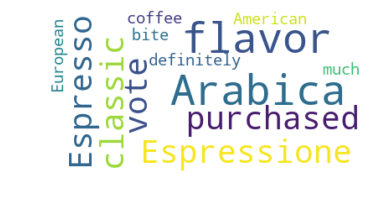

Review - 2
After years of using Starbuck's decaf and regular single serving espresso pods, I finally found a substitute that's more economical and MUCH better tasting.<p>I've used three different brands of pods in my Starbuck's Barista machine, and have found that the quality of the pod and the flavor of the espresso inside is, by far, the best in the Espressione pods. The flavor is more full bodied and stronger than in the Starbuck's pods. I actually use one pod to make two shots of espresso, and the flavor is more intense than when I buy my specialty drinks from Starbucks or other coffee houses.<p>Also, the pod itself is of very high quality. Each pod is individually wrapped in an airtight, hard foil wrapper, and I've never opened a package yet that contained a torn pod with coffee spilling out. Such is not the case with other lesser brands.<p>The tab on each pod is also handy, making it easier to switch out a hot spent pod with a new one when making a second round of espresso.


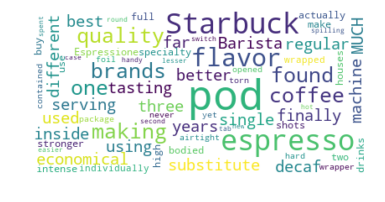

Review - 3
Few things I'd like to point out:<p>1.  &quot;Espresso&quot; is not a roast.  It's a drink.  In northern Italy they make espresso from Vienna roast, in southern Italy they use French.  Starbucks appears to be using French roast, so they should just label it French roast like any normal person would.<p>2.  The product description says &quot;Taste Espresso Roast as both a shot of espresso and brewed in a coffee press. This is one versatile coffee!&quot;  This is patently absurd.  It's pre-ground coffee, and it's either for use in espresso machines or presses, but not both.  Here's why:<p>Making a shot of espresso requires a very fine grind.  Making coffee press coffee requires a very course grind.  If you have ground coffee that is appropriate for espresso machines, it will pass through the filter in a coffee press and you will have a cup of sludge.  If you use ground coffee that does not pass through a press's filter in an espresso machine, you do not get espresso.  You get c

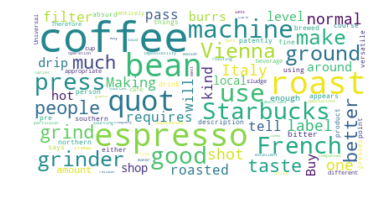

In [110]:
count = 1;
for i in range(len(cluster_3)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_3[i])
        cluster_wordcloud_generated_image_fun(cluster_3[i])
    count +=1

## k-medoids algorithm Implementation

In [18]:
# code reference https://github.com/letiantian/kmedoids
from sklearn.metrics.pairwise import pairwise_distances
tf_idf_data1 = tf_idf_data[0:10000,:]
# distance matrix
D = pairwise_distances(tf_idf_data1, metric='euclidean')

M, C = kMedoid(D, k = optimal_n_clusters)

****************************************************************************************************
Cluster -  1
No of reviews present in Cluster 1  are =  2952
****************************************************************************************************
Review -  1
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


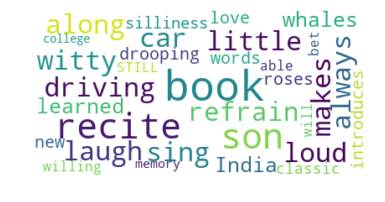

Review -  2
Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.


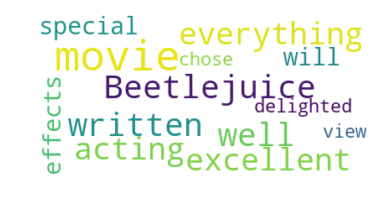



****************************************************************************************************
Cluster -  2
No of reviews present in Cluster 2  are =  1651
****************************************************************************************************
Review -  1
A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.


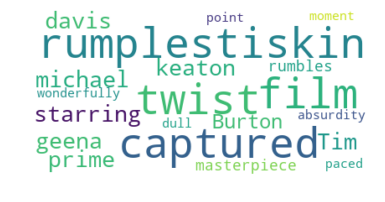

Review -  2
THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE COLLECTION. IT IS FILLED WITH COMEDY, ACTION, AND WHATEVER ELSE YOU WANT TO CALL IT.


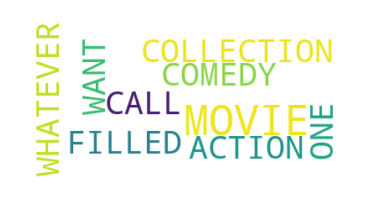



****************************************************************************************************
Cluster -  3
No of reviews present in Cluster 3  are =  5397
****************************************************************************************************
Review -  1
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


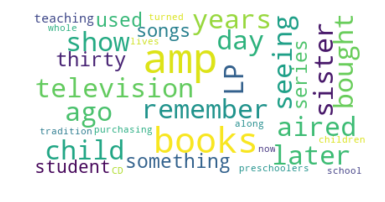

Review -  2
I, myself always enjoyed this movie, it's very funny and entertaining, so I didn't hesitate to pick up the clamshell edition.  I guess it was a marketing plan to make the movie more for families or something, but they  have eliminated all strong profanity and elements that are usually edited  in the television version.  YOU HAVE BEEN WARNED.  If you want the uncut  version, AVOID THE CLAMSHELL EDITION!


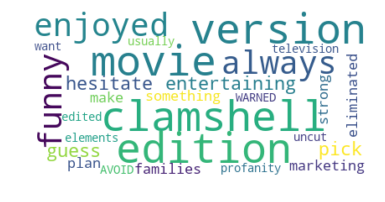

In [19]:
# Getting the reviews in all clusters
for label in C:
    print("*" * 100)
    print("Cluster - ",label+1)
    print('No of reviews present in Cluster',label+1,' are = ',C[label].shape[0])
    print("*" * 100)
#     print('\n')
    review_count = 1;
    for label_idx in C[label]:
        if review_count == 3:
            break;
        else:
            print('Review - ',review_count)
            print(reviews[label_idx])
            cluster_wordcloud_generated_image_fun(reviews[label_idx])
            review_count = review_count+1
    print('\n')


************ TF-IDF ENDS*******

## Word2Vec

In [20]:
#Word2Vec mode 
#spliting train sentence in words 
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in text:
    list_of_sent.append(sent.split())
    
print(len(text))
# print("\n--------------Spliting each sentence into words--------word list of ie data corpus---------\n")
# print(X_tr_list_of_sent[:2])
#word list of ie data corpus

100000


In [21]:
#The Word to Vec model produces a vocabulary, with each word being represented by 
#an n-dimensional numpy array 
data_w2v_model=Word2Vec(list_of_sent,min_count=1,size=50, workers=4)
data_w2v_model.wv['man']
wlist =list(data_w2v_model.wv.vocab)
# wlist is a list of words 
len(wlist)

37164

In [22]:
#CALCULATE AVG WORD2VEC FOR data
w2v_words = list(data_w2v_model.wv.vocab)
# compute average word2vec for each review.
data_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = data_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    data_sent_vectors.append(sent_vec)
print(len(data_sent_vectors))
print(len(data_sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [04:35<00:00, 362.69it/s]


100000
50


## K-Means Clustering Hyperparameter tuning:

In [114]:
n_clusters_lists = range(1,10)
cluster_errors = []

for clusters in tqdm(n_clusters_lists):
    model = KMeans(n_clusters = clusters, n_init=5)
    model.fit(data_sent_vectors)
    cluster_errors.append(model.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:06<00:00, 10.10s/it]


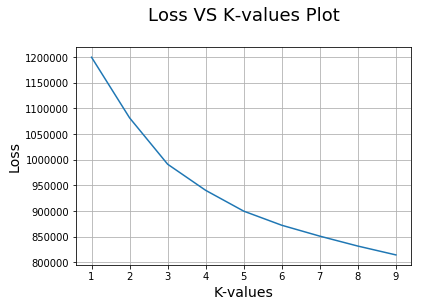

In [115]:
# Draw Loss VS K values plot
plt.plot(n_clusters_lists, cluster_errors)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

### K-Means Clustering implementation  with best n_clusters 

In [116]:
optimal_n_clusters = 3
# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_n_clusters, n_jobs=-1).fit(data_sent_vectors)

In [117]:
# getting original text i.e review column from the dataset 
reviews = final['Text'].values
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_2.append(reviews[i])
    else :
        cluster_3.append(reviews[i]) 

## Cluster - 1 review

Review - 1
THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE COLLECTION. IT IS FILLED WITH COMEDY, ACTION, AND WHATEVER ELSE YOU WANT TO CALL IT.


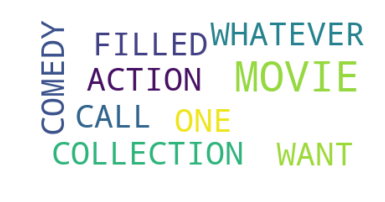

Review - 2
This are so much easier to use than the Wilson paste colors.  Colors are  vibrant, and do not taint the frosting like some colors can.  These are  simple to use, and do not make a mess.  My only complaint is that I did not  find these years ago.  This is a must have if you decorate often!


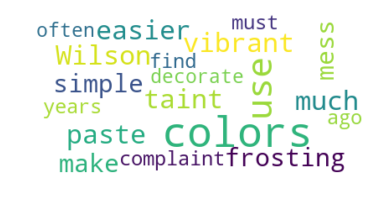

Review - 3
These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.


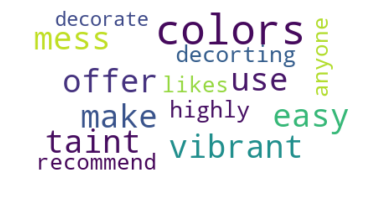

In [118]:
count = 1;
for i in range(len(cluster_1)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_1[i])
        cluster_wordcloud_generated_image_fun(cluster_1[i])
    count +=1

## Cluster - 2 review

Review - 1
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


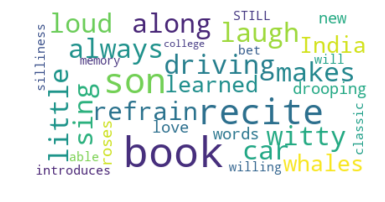

Review - 2
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


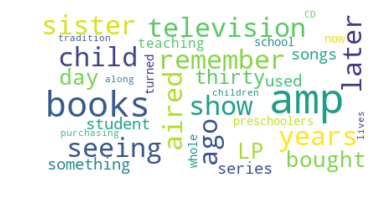

Review - 3
Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.


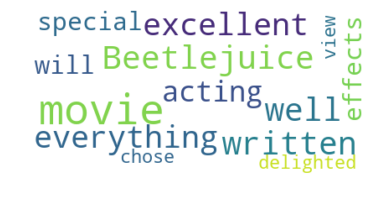

In [119]:
count = 1;
for i in range(len(cluster_2)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_2[i])
        cluster_wordcloud_generated_image_fun(cluster_2[i])
    count +=1

## Cluster - 3 review


Review - 1
For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.


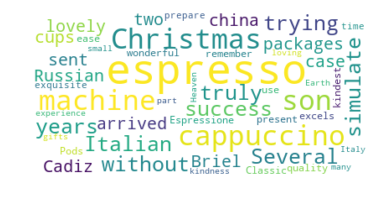

Review - 2
Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I compared these pods to Starbucks espresso pods (regular and decaf), and the Espressione are my favorite.  Only one warning:  150 pods (individually wrapped) take up a lot of space, so be sure you know where you're going to store them.  More good news:  each box of 150 is stamped with a "best if used by" date, which in my case was 16 months after the date of purchase.


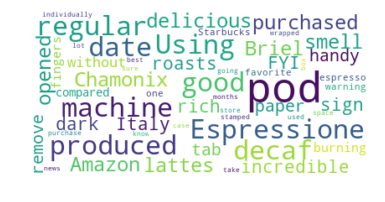

Review - 3
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).


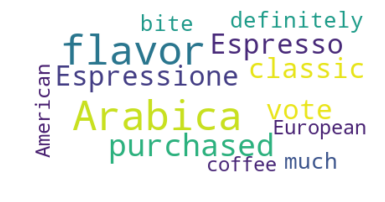

In [120]:
count = 1;
for i in range(len(cluster_3)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_3[i])
        cluster_wordcloud_generated_image_fun(cluster_3[i])
    count +=1

## k-medoids algorithm Implementation

In [23]:
# code reference https://github.com/letiantian/kmedoids
from sklearn.metrics.pairwise import pairwise_distances
data_sent_vectors1 = data_sent_vectors[0:10000]
# distance matrix
D = pairwise_distances(data_sent_vectors1, metric='euclidean')

M, C = kMedoid(D, k = optimal_n_clusters)

****************************************************************************************************
Cluster -  1
No of reviews present in Cluster 1  are =  5397
****************************************************************************************************
Review -  1
I'm getting crazy.I'm looking for Beatlejuice french version video.<p>Is it really impossible today not to find the French VHS version of this film ?<p>Could U please tell me something about it ? Tks


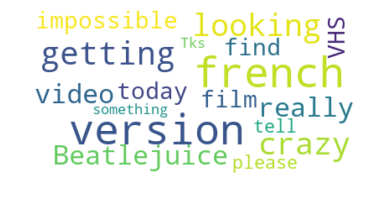

Review -  2
I'm getting crazy.<p>Is it really impossible today not to find the French VHS version of this film ?<p>Could U please tell me something about it ? Tks


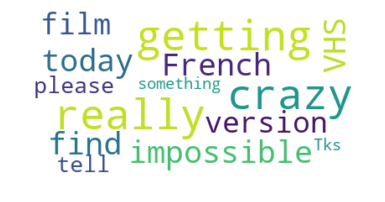



****************************************************************************************************
Cluster -  2
No of reviews present in Cluster 2  are =  989
****************************************************************************************************
Review -  1
A piquant, sweet, colorful treat.  Don't be put off by the Hot designation - no hotter than a pepperoncini.  Really great for adding a little color and sweetness to lots of dishes


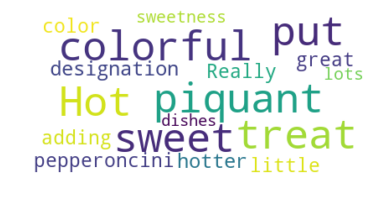

Review -  2
This cheese is soft, a bit runny just inside the rind, then rich and flaky in the center.  It is a mild goat cheese, but nonetheless flavorful.  Delicious!


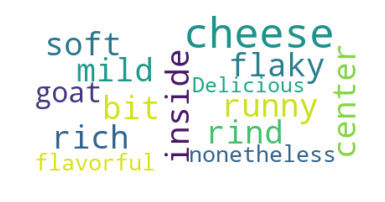



****************************************************************************************************
Cluster -  3
No of reviews present in Cluster 3  are =  3614
****************************************************************************************************
Review -  1
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


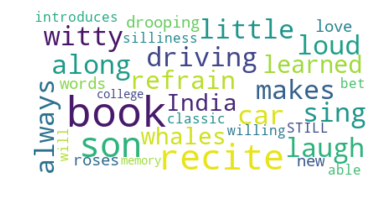

Review -  2
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


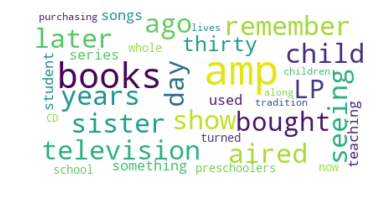

In [24]:
# Getting the reviews in all clusters
for label in C:
    print("*" * 100)
    print("Cluster - ",label+1)
    print('No of reviews present in Cluster',label+1,' are = ',C[label].shape[0])
    print("*" * 100)
#     print('\n')
    review_count = 1;
    for label_idx in C[label]:
        if review_count == 3:
            break;
        else:
            print('Review - ',review_count)
            print(reviews[label_idx])
            cluster_wordcloud_generated_image_fun(reviews[label_idx])
            review_count = review_count+1
    print('\n')


*****AVG Word2Vec******

## TF-IDF weighted Word2Vec

In [25]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [26]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

data_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = data_w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    data_tfidf_sent_vectors.append(sent_vec)
    row += 1

print(len(data_tfidf_sent_vectors))
print(len(data_tfidf_sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [05:29<00:00, 303.69it/s]


100000
50


## K-Means Clustering Hyperparameter tuning:

In [123]:
n_clusters_lists = range(1,10)
cluster_errors = []

for clusters in tqdm(n_clusters_lists):
    model = KMeans(n_clusters = clusters, n_init=5)
    model.fit(data_tfidf_sent_vectors)
    cluster_errors.append(model.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:04<00:00, 10.68s/it]


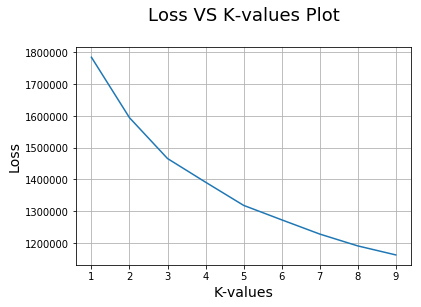

In [124]:
# Draw Loss VS K values plot
plt.plot(n_clusters_lists, cluster_errors)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

### K-Means Clustering implementation  with best n_clusters 

In [125]:
optimal_n_clusters = 3
# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_n_clusters, n_jobs=-1).fit(data_tfidf_sent_vectors)

In [126]:
# getting original text i.e review column from the dataset 
reviews = final['Text'].values
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_2.append(reviews[i])
    else :
        cluster_3.append(reviews[i]) 

## Cluster - 1 review

Review - 1
For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.


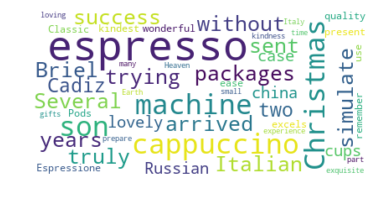

Review - 2
Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I compared these pods to Starbucks espresso pods (regular and decaf), and the Espressione are my favorite.  Only one warning:  150 pods (individually wrapped) take up a lot of space, so be sure you know where you're going to store them.  More good news:  each box of 150 is stamped with a "best if used by" date, which in my case was 16 months after the date of purchase.


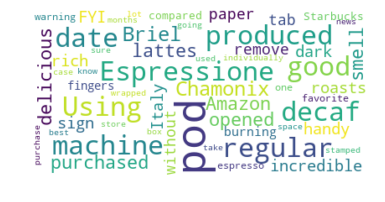

Review - 3
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).


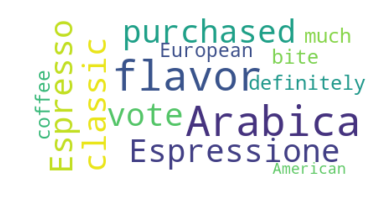

In [127]:
count = 1;
for i in range(len(cluster_1)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_1[i])
        cluster_wordcloud_generated_image_fun(cluster_1[i])
    count +=1

## Cluster - 2 review

Review - 1
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


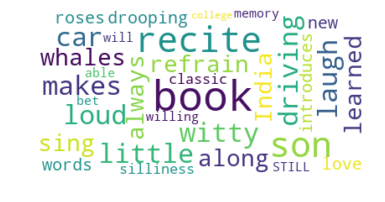

Review - 2
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


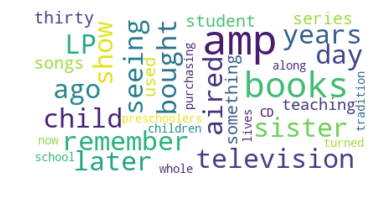

Review - 3
Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.


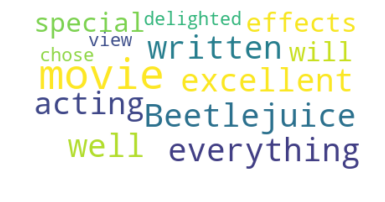

In [128]:
count = 1;
for i in range(len(cluster_2)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_2[i])
        cluster_wordcloud_generated_image_fun(cluster_2[i])
    count +=1

## Cluster - 3 review

Review - 1
This are so much easier to use than the Wilson paste colors.  Colors are  vibrant, and do not taint the frosting like some colors can.  These are  simple to use, and do not make a mess.  My only complaint is that I did not  find these years ago.  This is a must have if you decorate often!


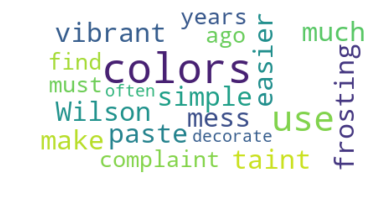

Review - 2
These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.


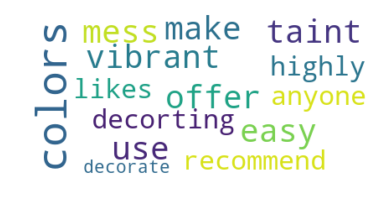

Review - 3
I don't know why anyone would ever use those little liquid food colors again after trying these pastes. The colors are more intense, and you can easily blend lovely shades for your icings. <p>Martha Stewart shows wonderful seasonal cookies from time to time on her TV show. A simple eggwhite-sugar icing on cookies in exciting colors makes such a wonderful table decoration as well as great dessert for parties, teas and other events. These paste colors are a must if you like to make frosted cookies or party cakes. <p>And these are especially fun if you have kids. A cookie-icing contest is a fun event for a birthday party, Christmas party or just a rainy afternoon.


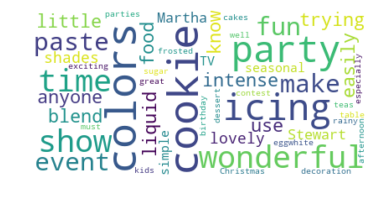

In [129]:
count = 1;
for i in range(len(cluster_3)):
    if i == 3:
        break;
    else:
        print("Review -",count)
        print(cluster_3[i])
        cluster_wordcloud_generated_image_fun(cluster_3[i])
    count +=1

## k-medoids algorithm Implementation

In [27]:
# code reference https://github.com/letiantian/kmedoids
from sklearn.metrics.pairwise import pairwise_distances
data_tfidf_sent_vectors1 = data_tfidf_sent_vectors[0:10000]
# distance matrix
D = pairwise_distances(data_tfidf_sent_vectors1, metric='euclidean')

M, C = kMedoid(D, k = optimal_n_clusters)

****************************************************************************************************
Cluster -  1
No of reviews present in Cluster 1  are =  1554
****************************************************************************************************
Review -  1
For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.


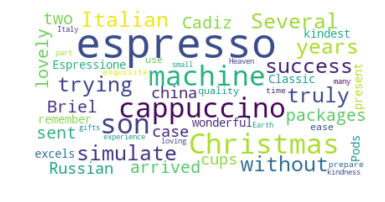

Review -  2
Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I compared these pods to Starbucks espresso pods (regular and decaf), and the Espressione are my favorite.  Only one warning:  150 pods (individually wrapped) take up a lot of space, so be sure you know where you're going to store them.  More good news:  each box of 150 is stamped with a "best if used by" date, which in my case was 16 months after the date of purchase.


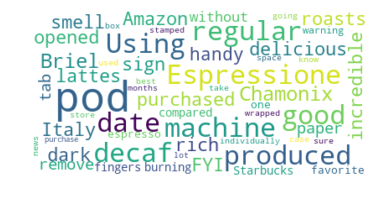



****************************************************************************************************
Cluster -  2
No of reviews present in Cluster 2  are =  2161
****************************************************************************************************
Review -  1
As a kid this ice cream was a favorite treat.  I've been told it has the highest milk fat content of any ice cream around and man can you taste it. This stuff is amazing. If you are a fan of premium ice cream this is the best stuff.


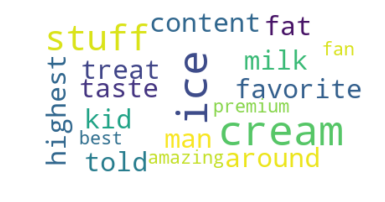

Review -  2
I have relied on these cake mixes for a few years and find them to be handy and to taste fine.  As with most sugar free products they taste great if you have not been eating sugar, but taste a little off if you switch straight from eating full sugar/fat desserts.  The cake mixes only require water to make. A teaspoon of real vanilla or almond extract improves the flavor.  I like to make the chocolate cake with iced coffee.  Then rather than use sugar free frosting (ugggh!) I sprinkle the top with either unsweetened cocoa or with chopped coffee beans.  The bitterness of the cocoa and the coffee beans enhances the sweetness of the cake. These mixes make a very thin eight-inch layer.  My local grocery store sells the mixes for $2.79 and rarely has flavors other than chocolate or yellow so the price and variety offered here is wonderful news.


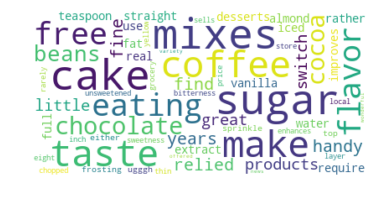



****************************************************************************************************
Cluster -  3
No of reviews present in Cluster 3  are =  6285
****************************************************************************************************
Review -  1
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


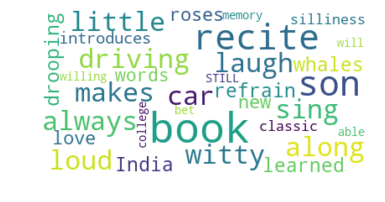

Review -  2
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


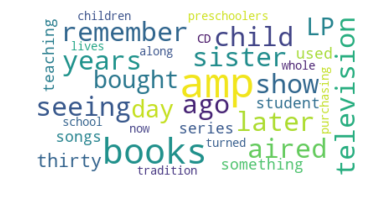

In [28]:
# Getting the reviews in all clusters
for label in C:
    print("*" * 100)
    print("Cluster - ",label+1)
    print('No of reviews present in Cluster',label+1,' are = ',C[label].shape[0])
    print("*" * 100)
#     print('\n')
    review_count = 1;
    for label_idx in C[label]:
        if review_count == 3:
            break;
        else:
            print('Review - ',review_count)
            print(reviews[label_idx])
            cluster_wordcloud_generated_image_fun(reviews[label_idx])
            review_count = review_count+1
    print('\n')


*****TF-IDF AVG W2V ENDS*****